# Filtering and Trimming messages

## Review

Now, we have a deeper understanding of a few things:

- How to customize the graph state schema
- How to define custom state reducers
- How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

## Messages as State

First, let's define some messages

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [
    AIMessage("So you said you were researching about physics, right?", name="Bot"),
]
messages.append(HumanMessage("Yes specifically qantum physics, can you tell me about electrons?", name="Guilherme"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching about physics, right?
================================ Human Message =================================
Name: Guilherme

Yes specifically qantum physics, can you tell me about electrons?


Recall we can pass them to a chat model.

In [3]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.1",
    base_url="http://localhost:11434",
    max_tokens=1000,
    temperature=0.8
    )
llm.invoke(messages)

AIMessage(content='Quantum physics is a fascinating field. Electrons are indeed a crucial part of it.\n\nElectrons are subatomic particles that orbit the nucleus of an atom. They\'re negatively charged and play a vital role in the structure and behavior of matter. Here are some key aspects of electrons:\n\n1. **Wave-particle duality**: Electrons can exhibit both wave-like and particle-like properties depending on how they\'re observed. In quantum mechanics, this is known as wave-particle duality.\n2. **Quantum spin**: Electrons have an intrinsic angular momentum called spin, which is a fundamental property of particles in the quantum world.\n3. **Energy levels**: Electrons occupy specific energy levels or shells around the nucleus, and each shell has a limited number of available energy states.\n4. **Orbitals**: The regions around the nucleus where electrons are likely to be found are called orbitals. These can be spherical (s-orbitals) or dumbbell-shaped (p-orbitals).\n5. **Quantizati

We can run our chat model in a simple graph with `MessagesState`

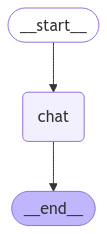

In [4]:
from IPython.display import display, Image
from langgraph.graph import MessagesState, StateGraph, START, END

# Node
def chat_model(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("chat", chat_model)

# Add edges
builder.add_edge(START, "chat")
builder.add_edge("chat", END)

# Compile the graph
graph = builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching about physics, right?
================================ Human Message =================================
Name: Guilherme

Yes specifically qantum physics, can you tell me about electrons?
================================== Ai Message ==================================

Electrons are fascinating particles that play a crucial role in quantum physics. Here's an introduction:

**What is an electron?**

An electron is a subatomic particle that orbits the nucleus of an atom. It has a negative charge and is one of the three main components of matter, along with protons and neutrons.

**Properties of electrons:**

1. **Charge:** Electrons have a negative charge (-e), which is equal in magnitude to the positive charge (+e) carried by protons.
2. **Mass:** The mass of an electron is approximately 9.11 x 10^-31 kilograms, which is much smaller than that of protons and neutron

## Reducer

A pratical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

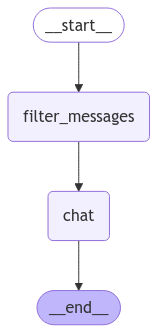

In [6]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("filter_messages", filter_messages)
builder.add_node("chat", chat_model)

# Add edges
builder.add_edge(START, "filter_messages")
builder.add_edge("filter_messages", "chat")
builder.add_edge("chat", END)

# Compile the graph
graph = builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# Message list with preamble
messages = [
    AIMessage("Hi", name="Bot"),
]
messages.append(HumanMessage("Hello, I'm Guilherme", name="Guilherme"))
messages.append(AIMessage("Nice to meet you Guilherme, what are you interested in?", name="Bot"))
messages.append(HumanMessage("I'm interested in quantum physics", name="Guilherme"))

output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Nice to meet you Guilherme, what are you interested in?
================================ Human Message =================================
Name: Guilherme

I'm interested in quantum physics
================================== Ai Message ==================================

That's a fascinating field! Quantum physics is the study of the behavior of matter and energy at an atomic and subatomic level. It's a branch of physics that explores the strange and often counterintuitive world of particles and waves.

What specific aspects of quantum physics interest you? Are you drawn to topics like:

1. Schrödinger's cat and the implications of superposition?
2. The principles of wave-particle duality and the EPR paradox?
3. Quantum entanglement and its potential applications in quantum computing?
4. The Heisenberg Uncertainty Principle and its limitations on measurement?

Or perhaps you're curious about the p

## Filtering messages

If you don't need or want to  modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model

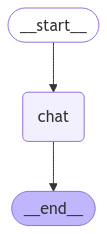

In [8]:
# Node
def chat_model(state: MessagesState):
    return {"messages": llm.invoke(state["messages"][-1:])}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("chat", chat_model)

# Add edges
builder.add_edge(START, "chat")
builder.add_edge("chat", END)

# Compile the graph
graph = builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of mmessages, append the above LLM response, and append a follow-up question.

In [10]:
messages.append(output["messages"][-1])
messages.append(HumanMessage("Tell me more about Heisenberg's uncertainty principle", name="Guilherme"))
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi
================================ Human Message =================================
Name: Guilherme

Hello, I'm Guilherme
================================== Ai Message ==================================
Name: Bot

Nice to meet you Guilherme, what are you interested in?
================================ Human Message =================================
Name: Guilherme

I'm interested in quantum physics
================================== Ai Message ==================================

That's a fascinating field! Quantum physics is the study of the behavior of matter and energy at an atomic and subatomic level. It's a branch of physics that explores the strange and often counterintuitive world of particles and waves.

What specific aspects of quantum physics interest you? Are you drawn to topics like:

1. Schrödinger's cat and the implications of superposition?
2. The principles of wave-particle dualit

In [11]:
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()


================================== Ai Message ==================================
Name: Bot

Hi
================================ Human Message =================================
Name: Guilherme

Hello, I'm Guilherme
================================== Ai Message ==================================
Name: Bot

Nice to meet you Guilherme, what are you interested in?
================================ Human Message =================================
Name: Guilherme

I'm interested in quantum physics
================================== Ai Message ==================================

That's a fascinating field! Quantum physics is the study of the behavior of matter and energy at an atomic and subatomic level. It's a branch of physics that explores the strange and often counterintuitive world of particles and waves.

What specific aspects of quantum physics interest you? Are you drawn to topics like:

1. Schrödinger's cat and the implications of superposition?
2. The principles of wave-particle dualit

## Trim Messages

Another approach is to trim messages, base dupon a set number of tokens.

This restricts the message history to specified number of tokens.

While filtering only return a post-hoc subset of the messages between agents, trimming restricts the  number of tokens that a chat model can use to respond.

See the `trim_messages` below:

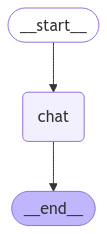

In [22]:
from langchain_core.messages import trim_messages

# Node
def chat_model(state: MessagesState):
    messages = trim_messages(
        state["messages"],
        max_tokens=500,
        strategy="last",
        token_counter = ChatOllama(model="llama3.1", base_url="http://localhost:11434"),
        allow_partial=True
    )
    return {"messages": [llm.invoke(messages)]}

# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("chat", chat_model)

# Add edges
builder.add_edge(START, "chat")
builder.add_edge("chat", END)

# Compile the graph
graph = builder.compile()

# View the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
messages.append(output["messages"][-1])
messages.append(HumanMessage("Tell me more about Planck's constant", name="Guilherme"))

In [24]:
trim_messages(messages, max_tokens=500, strategy="last", token_counter=llm)

[HumanMessage(content="Tell me more about Planck's constant", additional_kwargs={}, response_metadata={}, name='Guilherme')]

In [25]:
messages_out_trim = graph.invoke({"messages": messages})

In [26]:
messages_out_trim

{'messages': [AIMessage(content='Hi', additional_kwargs={}, response_metadata={}, name='Bot', id='b3138fbe-3273-44e3-88de-e0ce5ff9b800'),
  HumanMessage(content="Hello, I'm Guilherme", additional_kwargs={}, response_metadata={}, name='Guilherme', id='5b13a356-b9e6-4ee8-9b53-8bb9821de138'),
  AIMessage(content='Nice to meet you Guilherme, what are you interested in?', additional_kwargs={}, response_metadata={}, name='Bot', id='5fb4b102-95be-40cf-b599-b7295997440d'),
  HumanMessage(content="I'm interested in quantum physics", additional_kwargs={}, response_metadata={}, name='Guilherme', id='95638f17-b463-4d59-bbf7-1c9861ba2ab6'),
  AIMessage(content="That's a fascinating field! Quantum physics is the study of the behavior of matter and energy at an atomic and subatomic level. It's a branch of physics that explores the strange and often counterintuitive world of particles and waves.\n\nWhat specific aspects of quantum physics interest you? Are you drawn to topics like:\n\n1. Schrödinger's